In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")

In [2]:
def get_constrained_region(path, region):
    df = pd.read_csv(path, sep="\t", usecols=["hgnc",])
    df["region"] = region
    return df

In [3]:
regions = ["distal","long_exon","new","nmd"]
paths = [f"../outputs/constrained_transcripts_{r}.tsv" for r in regions]

df = pd.concat([get_constrained_region(p, r) for p, r in zip(paths, regions)]).drop_duplicates()

In [4]:
gnomad = pd.read_csv("../data/supplementary_dataset_11_full_constraint_metrics.tsv", sep="\t")
gnomad = gnomad[(gnomad["pLI"] > 0.9) | (gnomad["oe_lof_upper"] < 0.35)]
gnomad = gnomad[["gene"]].rename(columns={"gene":"hgnc"}).assign(region="gnomad").drop_duplicates()

In [5]:
df = pd.concat([df, gnomad])
df.shape

(5339, 2)

In [6]:
disease_genes = pd.read_csv("../outputs/panel_app_gms_rare_disease_genes.tsv", sep="\t")
dg = disease_genes.copy()[["hgnc","moi"]]

In [7]:
moi = ["hemizygous","both","monoallelic","biallelic",] # The order matters
for i in moi:
    m1 = dg["moi"].str.lower().str.contains(i).fillna(False)
    dg.loc[m1, "moi"] = i
dg.loc[~dg.moi.isin(moi), "moi"] = np.nan
dg["moi"] = dg["moi"].replace("hemizygous","x-linked") # For clarity
dg["moi"] = dg["moi"].replace("both", "monoallelic,biallelic").str.split(",")
dg = dg.explode("moi").drop_duplicates().dropna()
dg["moi"] = dg.groupby("hgnc")["moi"].transform(lambda x: ",".join(x)).replace("biallelic,monoallelic", "monoallelic,biallelic")
dg = dg.drop_duplicates()

In [8]:
df_spare = df.copy()

In [9]:
df = df_spare.copy()

In [10]:
df["morbid"] = np.where(df["hgnc"].isin(dg["hgnc"]), 1, 0)
df = df.merge(dg, how="left")

moi = ["monoallelic","biallelic","x-linked"]
for i in moi: 
    df[i] = np.where(df.moi.fillna("").str.contains(i), 1, 0)

df = df.melt(id_vars=["hgnc","region"], value_vars=["morbid","monoallelic","biallelic","x-linked"], var_name="PanelApp")

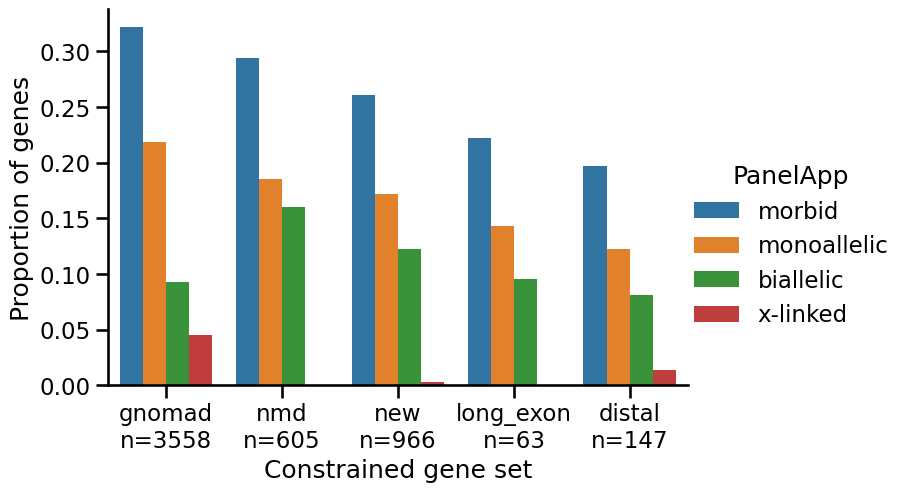

In [11]:
regions = ["gnomad","nmd","new","long_exon","distal"]
gene_count = [df.drop_duplicates(["hgnc","region"]).groupby("region").nunique()["hgnc"][r] for r in regions]

g = sns.catplot(
    kind="bar",
    data=df,
    x="region",
    y="value",
    hue="PanelApp",
    estimator="mean",
    errorbar=None,
    order=regions,
    aspect=1.5
)
g.set(
    xlabel="Constrained gene set",
    ylabel="Proportion of genes",
    xticklabels=[f"{r}\nn={n}" for r, n in zip(regions, gene_count)]
)